# **Modélisation statistique**
Nous allons mener des régressions linéaires de la production électrique éolienne (données API RTE) sur les données météorologiques de vents (données API ...)

Dans un premier temps, nous allons créer un data frame qui contiendra la moyenne nationale de la production électrique éolienne ainsi que la moyenne des vents nationaux, heure par heure pour l'année 2021.
Ensuite, nous affinerons l'analyse en faisant des régressions par région/année.

### **1) Récupération des données**

Dans un premier temps, nous cherchons à mettre les dates des données météorologique et des données RTE dans le même format. Le format cherché est, par exemple pour le 5 mai 2020 à 12h:

**2020-05-05:12:00**

#### **a) Données météorologiques**

In [1]:
import pandas as pd
import sys
import csv

csv.field_size_limit(sys.maxsize)

131072

In [2]:
donnees_vent = pd.read_csv('donnees_vent.csv', sep=",", names=['Index', 'Time', 'Windspeed'], engine='python', error_bad_lines=False)

donnees_vent_prediction = pd.read_csv('donnees_vent_prediction.csv', sep=",", names=['Index', 'Time', 'Windspeed'], engine='python', error_bad_lines=False)

/tmp/ipykernel_813/83721686.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  donnees_vent = pd.read_csv('donnees_vent.csv', sep=",", names=['Index', 'Time', 'Windspeed'], engine='python', error_bad_lines=False)
Skipping line 206: unexpected end of data
/tmp/ipykernel_813/83721686.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  donnees_vent_prediction = pd.read_csv('donnees_vent_prediction.csv', sep=",", names=['Index', 'Time', 'Windspeed'], engine='python', error_bad_lines=False)


In [3]:
donnees_vent.head()

,Index,Time,Windspeed
0,0,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[1.43, 1.25, 1.7, 2.02, 2.08, 2.42, 2.64, 2.86..."
1,1,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
2,2,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
3,3,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[2.1, 2.18, 2.22, 2.18, 1.66, 1.75, 1.7, 1.71,..."
4,12,"['2021-01-01T00:00', '2021-01-01T01:00', '2021...","[1.66, 1.88, 1.97, 2.25, 1.43, 1.51, 1.43, 1.3..."


In [4]:
donnees_vent_prediction.head()

,Index,Time,Windspeed
0,0,"['2022-12-13T00:00', '2022-12-13T01:00', '2022...","[4.21, 3.23, 3.99, 2.79, 3.6, 3.42, 1.0, 2.24,..."
1,1,"['2022-12-13T00:00', '2022-12-13T01:00', '2022...","[3.0, 2.45, 2.09, 2.1, 1.92, 1.62, 1.8, 1.81, ..."
2,2,"['2022-12-13T00:00', '2022-12-13T01:00', '2022...","[3.0, 2.45, 2.09, 2.1, 1.92, 1.62, 1.8, 1.81, ..."
3,3,"['2022-12-13T00:00', '2022-12-13T01:00', '2022...","[3.31, 2.84, 2.38, 2.33, 2.15, 1.93, 2.2, 2.24..."
4,4,"['2022-12-13T00:00', '2022-12-13T01:00', '2022...","[4.74, 4.96, 4.8, 4.7, 4.39, 3.89, 2.91, 2.2, ..."


Le format des données est le suivant:

-L'index représente le numéro des éoliennes, numérotées de 0 à XXXX.

-La variable "Time" contient la liste de toutes les dates auxquelles on observe la vitesse du vent à la position de l'éolienne.

-La variable "Windspeed" contient la liste de la vitesse des vents.

Dans un premier temps, on va chercher à "nettoyer" la variable "Time" afin de créer une liste de dates harmonisées.

On va ajouter une colonne représentant la longueur du rotor de l'éolienne à partir de la précédente base de donnée.

In [5]:
df = pd.read_csv("eolien.csv", sep=";")

In [6]:
donnees_vent = donnees_vent.merge(df['diametre_rotor'],how = 'left',left_on = 'Index',right_index = True)
donnees_vent_prediction = donnees_vent_prediction.merge(df['diametre_rotor'],how = 'left',left_on = 'Index',right_index = True)

In [7]:
caracteres_time = ["'","[","]","T", ","]
    
for string in caracteres_time:
    donnees_vent["Time"] = donnees_vent["Time"].apply(lambda x: x.replace(string, ''))
    donnees_vent_prediction["Time"] = donnees_vent["Time"].apply(lambda x: x.replace(string, ''))    

In [8]:
caracteres_vent = ["[", "]", ","]

for string in caracteres_vent:
    donnees_vent["Windspeed"] = donnees_vent["Windspeed"].apply(lambda x: x.replace(string, ''))
    donnees_vent_prediction["Windspeed"] = donnees_vent["Windspeed"].apply(lambda x: x.replace(string, ''))

Maintenant que les variables "Time" et "Windspeed" sont nettoyées, on va utiliser la fonction explode afin d'avoir une base de données "classique" pour pouvoir faire des régressions. Nous allons étendre les listes afin que chaque vent soit associé à une date précise.

Premièrement, on convertit nos données considérés comme "string" en liste.

In [9]:
donnees_vent["Time"] = donnees_vent["Time"].str.split(' ')
donnees_vent["Time"] = donnees_vent["Time"].tolist()

donnees_vent_prediction["Time"] = donnees_vent_prediction["Time"].str.split(' ')
donnees_vent_prediction["Time"] = donnees_vent_prediction["Time"].tolist()

In [10]:
donnees_vent["Windspeed"] = donnees_vent["Windspeed"].str.split(' ')
donnees_vent["Windspeed"] = donnees_vent["Windspeed"].tolist()

donnees_vent_prediction["Windspeed"] = donnees_vent_prediction["Windspeed"].str.split(' ')
donnees_vent_prediction["Windspeed"] = donnees_vent_prediction["Windspeed"].tolist()

In [11]:
donnees_vent = donnees_vent.set_index(['Index']).apply(pd.Series.explode).reset_index()

donnees_vent_prediction = donnees_vent_prediction.set_index(['Index']).apply(pd.Series.explode).reset_index()

In [12]:
donnees_vent["Windspeed"] = donnees_vent["Windspeed"].astype(float)
donnees_vent["Index"] = donnees_vent["Index"].astype(str)

donnees_vent_prediction["Windspeed"] = donnees_vent_prediction["Windspeed"].astype(float)
donnees_vent_prediction["Index"] = donnees_vent_prediction["Index"].astype(str)

In [13]:
donnees_vent["Windspeed_cubed"] = donnees_vent["Windspeed"].pow(3)
donnees_vent_prediction["Windspeed_cubed"] = donnees_vent_prediction["Windspeed"].pow(3)

In [14]:
donnees_vent["rotor_carre"] = donnees_vent["diametre_rotor"].pow(2)

donnees_vent_prediction["rotor_carre"] = donnees_vent_prediction["diametre_rotor"].pow(2)

In [15]:
def weighted_average(group):
    d = group['rotor_carre']
    v = group['Windspeed_cubed']
    return (d*v).sum()

vent_somme = donnees_vent.groupby(['Time']).apply(weighted_average)
vent_somme_prediction = donnees_vent_prediction.groupby(['Time']).apply(weighted_average)

In [16]:
vent_somme = vent_somme.to_frame()
vent_somme_prediction = vent_somme_prediction.to_frame()

#### **b) Données RTE**
On importe les données RTE auparavant obtenu grâce à une API.

**Pour l'instant:** données test de Janvier à Février 2020

In [18]:
data_RTE = pd.read_csv('RTE_test.xls')

In [19]:
data_RTE

,Unnamed: 0,start_date,end_date,updated_date,value
0,0,2021-01-01 00:00:00+01:00,2021-01-01 01:00:00+01:00,2021-01-01T00:40:58+01:00,1082
1,1,2021-01-01 01:00:00+01:00,2021-01-01 02:00:00+01:00,2021-01-01T01:40:58+01:00,1075
2,2,2021-01-01 02:00:00+01:00,2021-01-01 03:00:00+01:00,2021-01-01T02:40:55+01:00,1086
3,3,2021-01-01 03:00:00+01:00,2021-01-01 04:00:00+01:00,2021-01-01T03:40:57+01:00,1149
4,4,2021-01-01 04:00:00+01:00,2021-01-01 05:00:00+01:00,2021-01-01T04:40:54+01:00,1170
...,...,...,...,...,...
3618,3618,2021-05-31 19:00:00+02:00,2021-05-31 20:00:00+02:00,2021-05-31T18:38:14+02:00,2304
3619,3619,2021-05-31 20:00:00+02:00,2021-05-31 21:00:00+02:00,2021-05-31T19:33:04+02:00,2316
3620,3620,2021-05-31 21:00:00+02:00,2021-05-31 22:00:00+02:00,2021-05-31T20:34:02+02:00,2845
3621,3621,2021-05-31 22:00:00+02:00,2021-05-31 23:00:00+02:00,2021-05-31T21:33:59+02:00,3840


On renomme les trois colonnes nécessaires et on enlève les colonnes inutiles

In [20]:
columns_to_drop = ['end_date', 'updated_date']
data_RTE = data_RTE.drop(columns_to_drop, axis=1)

columns_to_rename = {'Unnamed: 0': 'Index', 'start_date': 'Time', 'value': 'Electricity'}
data_RTE = data_RTE.rename(columns=columns_to_rename)

On enlève les éléments de la date inutile afin d'harmoniser

In [21]:
caracteres = ["+01:00"," ","+02:00"]
    
for string in caracteres:
    data_RTE["Time"] = data_RTE["Time"].apply(lambda x: x.replace(string, ''))

data_RTE["Time"] = data_RTE["Time"].str[:-3]

In [22]:
data_RTE

,Index,Time,Electricity
0,0,2021-01-0100:00,1082
1,1,2021-01-0101:00,1075
2,2,2021-01-0102:00,1086
3,3,2021-01-0103:00,1149
4,4,2021-01-0104:00,1170
...,...,...,...
3618,3618,2021-05-3119:00,2304
3619,3619,2021-05-3120:00,2316
3620,3620,2021-05-3121:00,2845
3621,3621,2021-05-3122:00,3840


Les dates sont bien au format harmonisé voulu.

#### **c) Merge des deux database**

In [23]:
vent_somme.columns = ['Windspeed_cubed']
vent_somme_prediction.columns = ['Windspeed_cubed']

In [25]:
vent_somme

,Windspeed_cubed
Time,
2021-01-0100:00,7.021859e+06
2021-01-0101:00,7.445100e+06
2021-01-0102:00,8.663478e+06
2021-01-0103:00,8.906593e+06
2021-01-0104:00,9.552695e+06
...,...
2021-12-3119:00,8.098053e+07
2021-12-3120:00,1.008941e+08
2021-12-3121:00,9.213382e+07


In [26]:
data = data_RTE.merge(vent_somme, on='Time')

In [27]:
data['Electricity'] = (1e6)*data['Electricity']

In [28]:
data

,Index,Time,Electricity,Windspeed_cubed
0,0,2021-01-0100:00,1.082000e+09,7.021859e+06
1,1,2021-01-0101:00,1.075000e+09,7.445100e+06
2,2,2021-01-0102:00,1.086000e+09,8.663478e+06
3,3,2021-01-0103:00,1.149000e+09,8.906593e+06
4,4,2021-01-0104:00,1.170000e+09,9.552695e+06
...,...,...,...,...
3618,3618,2021-05-3119:00,2.304000e+09,2.874686e+07
3619,3619,2021-05-3120:00,2.316000e+09,3.621167e+07
3620,3620,2021-05-3121:00,2.845000e+09,4.608323e+07
3621,3621,2021-05-3122:00,3.840000e+09,6.185617e+07


### **2) Les régressions linéaires**

Dans un premier temps, on va regresser l'électricité produite sur le vent au cube afin de retrouver le coefficient $1/2 \rho S$ où $S = \pi/4 d^2$ est la surface de brassage de l'éolienne avec $d$ le diamètre du rotor. 

Ensuite on régressera le log de l'électricité produite sur le log du vent afin de retrouver le cube.

#### **a) Spécification de base: les vents ne sont pas pondérés**

In [29]:
import statsmodels.formula.api as smf

def regression_results_no_cte(x, y, z):
    model = smf.ols(y+"~"+z+"-1", data=x).fit(cov_type='HC1')
    predictions = model.predict(x)
    print(model.summary())
    
def regression_results(x, y, z):
    model = smf.ols(y+"~"+z, data=x).fit(cov_type='HC1')
    predictions = model.predict(x)
    print(model.summary())
    
regression_results_no_cte(data, "Electricity", "Windspeed_cubed")  

                                 OLS Regression Results                                
Dep. Variable:            Electricity   R-squared (uncentered):                   0.776
Model:                            OLS   Adj. R-squared (uncentered):              0.776
Method:                 Least Squares   F-statistic:                              2202.
Date:                Fri, 16 Dec 2022   Prob (F-statistic):                        0.00
Time:                        07:40:33   Log-Likelihood:                         -83881.
No. Observations:                3623   AIC:                                  1.678e+05
Df Residuals:                    3622   BIC:                                  1.678e+05
Df Model:                           1                                                  
Covariance Type:                  HC1                                                  
                      coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------

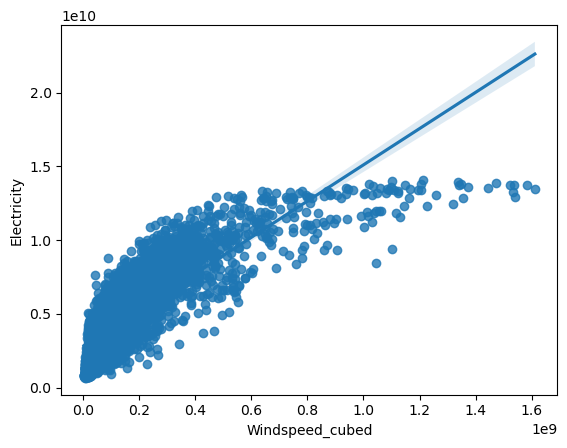

In [30]:
import seaborn as sns

def plot_linear_regression(x, y, z):
    plot = sns.regplot(x=z, y=y, data=x)
    return plot

plot = plot_linear_regression(data, "Electricity", "Windspeed_cubed")

#### **Deuxième régression: avec log**


In [32]:
import numpy as np
data['Electricity_log'] = np.log(data['Electricity'])
data['Windspeed_log'] = np.log(data['Windspeed_cubed'])/3

In [33]:
regression_results(data, "Electricity_log", "Windspeed_log")  

                            OLS Regression Results                            
Dep. Variable:        Electricity_log   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                 1.291e+04
Date:                Fri, 16 Dec 2022   Prob (F-statistic):               0.00
Time:                        07:41:50   Log-Likelihood:                -1314.0
No. Observations:                3623   AIC:                             2632.
Df Residuals:                    3621   BIC:                             2644.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.1443      0.090    135.096

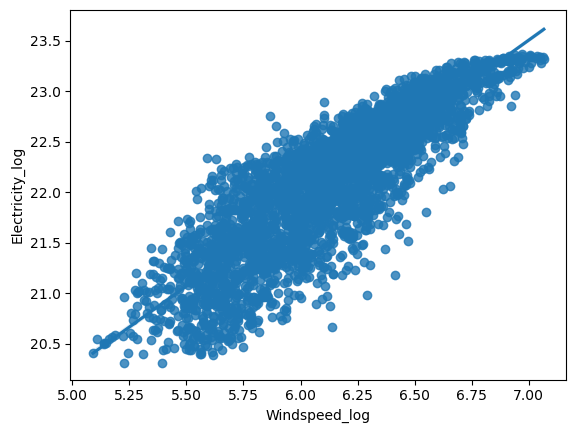

In [34]:
plot = plot_linear_regression(data, "Electricity_log", "Windspeed_log")

#### **c) Troisième spécification : régression avec la cassure**

In [35]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np

In [36]:
model = DecisionTreeRegressor(min_samples_leaf=10, max_depth=1)

In [37]:
X = data['Windspeed_cubed'].to_numpy()
X = X.reshape(-1, 1)

y = data['Electricity'].to_numpy()

In [38]:
model.fit(X, y)
y_pred = model.predict(X)

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

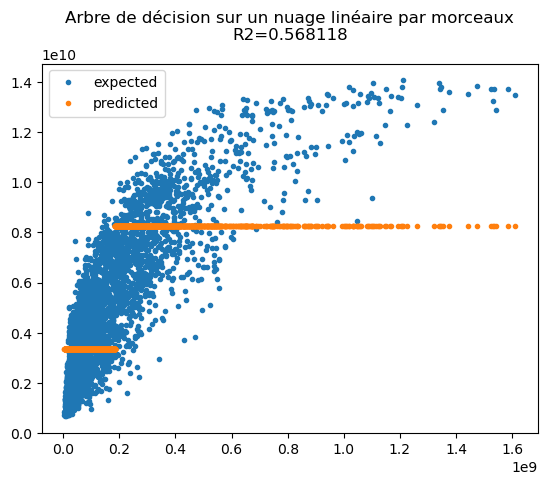

In [40]:
fig, ax = plt.subplots(1, 1)
ax.plot(X, y, ".", label="expected")
ax.plot(X, y_pred, ".", label="predicted")
ax.legend()
r2 = r2_score(y, y_pred)
ax.set_title("Arbre de décision sur un nuage linéaire par morceaux\nR2=%f" % r2);

In [41]:
th = list(sorted(set(model.tree_.threshold)))
th += [(th[i] + th[i-1])/2 for i in range(1,len(th)-1)]
th = list(sorted(th))
th

[-2.0, 185405296.0]

In [ ]:
#regression_results(data_pondéré, "Electricity", "")  

In [ ]:
#plot = plot_linear_regression(data_pondéré, "Electricity", "")

#### **e) Cinquième spécification : masse volumique de l'air**

In [37]:
rho_air = 1.2

def calcul_energie(diametre_rotor,vitesse_vent):
    return 16/27/2 * rho_air * np.pi/4 * diametre_rotor**2 * np.power(vitesse_vent,3)

In [51]:
data['Energie'] = calcul_energie(data['diametre_rotor'],donnees_vent['Windspeed'])

#### **f) Régressions avec données prévisionnelles de vent (4 jours)**

#### **i) Lasso regression**

In [139]:
def g(x):
    return np.log(x)

In [140]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso()
lasso_reg.fit(g(X), y)

Lasso()

In [137]:
X_pred = vent_moyen_prediction['Windspeed_cubed'].to_numpy()
X_pred = X_pred.reshape(-1, 1)

y_pred_lasso = lasso_reg.predict(X_pred)

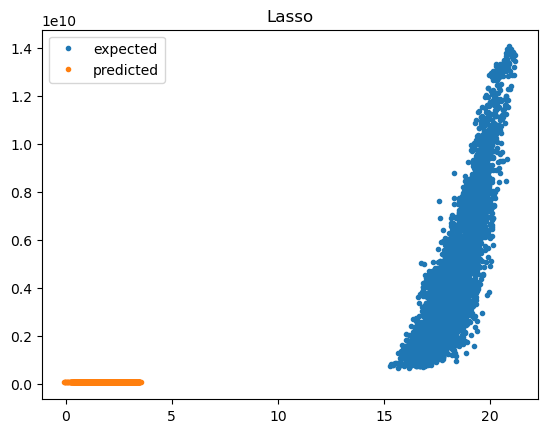

In [142]:
fig, lasso = plt.subplots(1, 1)
lasso.plot(g(X), y, ".", label="expected")
lasso.plot(g(X_pred), y_pred_lasso, ".", label="predicted")
lasso.legend()
lasso.set_title("Lasso");

#### **i) Ridge regression**

In [60]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge()
ridge_reg.fit(X, y)
y_pred_ridge = ridge_reg.predict(X_pred)

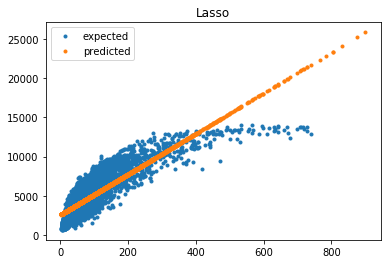

In [61]:
fig, ridge = plt.subplots(1, 1)
ridge.plot(X, y, ".", label="expected")
ridge.plot(X_pred, y_pred_lasso, ".", label="predicted")
ridge.legend()
ridge.set_title("Ridge");